## Lecture 4: Advantages of Databases - Complex types & queries

### 1. Unstructured data (JSON)
- Why are we using unstructured data?
    - We are storing and retrieving unstructured data (iPython notebooks, web data, free-form inputs)
    - Users are creating data with arbitrary properties
    - Event tracking (where event elements may vary)
    - There are a large number of optional parameters
    - Creating a data model/schema is inefficient (in that case)
    
- Postgres Support:
    - Effectively mapping & validating JSON
    - Providing tools to search & locate data
    - JSON and JSONB-types
    

**What is JSON?**
- JSON: JavaScript Object Notation.
- JSON is a syntax for storing and exchanging data.
- JSON is text, written with JavaScript object notation.

### 2. JSONB Fields
* JSONB is JSON
    - +JSONB is transformed to binary representation before storage
    - +JSONB can be hashed (supports DISTINCT)
    - +JSONB can be indexed
    - -JSONB is slower to INSERT (because it must be converted from JSON)

### 3. Postgres vs document store DB
- Postgres supports:
    - Constraints & indexing of unstructured data
    - Zero data loss (ACID compliance)
    - For sharding of big data is only fairly recent
    - Postgres can pair unstructured elements with relational data
    - Postgres is not as fast at managing data ingest.
    
    
- BASE (Basically Available, Soft state, Eventual consistency)
    - Operations are always happening (?)
    - Queue of data (?)
    - What is available may actually change
    - If something happened to a database, you may lose data -> less durable
    
    
> In the NoSQL database world, ACID transactions are less fashionable as some databases have loosened the requirements for immediate consistency, data freshness and accuracy in order to gain other benefits, like scale and resilience.

- Basic Availability
    - The database appears to work most of the time.
- Soft-state
    - Stores don’t have to be write-consistent, nor do different replicas have to be mutually consistent all the time.
- Eventual consistency
    - Stores exhibit consistency at some later point (e.g., lazily at read time).
    
> A BASE data store values availability (since that’s important for scale), but it doesn’t offer guaranteed consistency of replicated data at write time. Overall, the BASE consistency model provides a less strict assurance than ACID: data will be consistent in the future, either at read time (e.g., Riak) or it will always be consistent, but only for certain processed past snapshots (e.g., Datomic).

[more information](https://neo4j.com/blog/acid-vs-base-consistency-models-explained/)

### 4. An example of unstructured data
- Github markdown
    - It is a type of unstructured data
    - However, you can turn it into structured data.
    - Whether it makes sense to do that depends on the data.

### 5. A JSON/JSONB Object
- A broad range of JSON Operators is available in Postgres

```sql
SELECT parsereadme -> 2 AS result
FROM readmejson
```

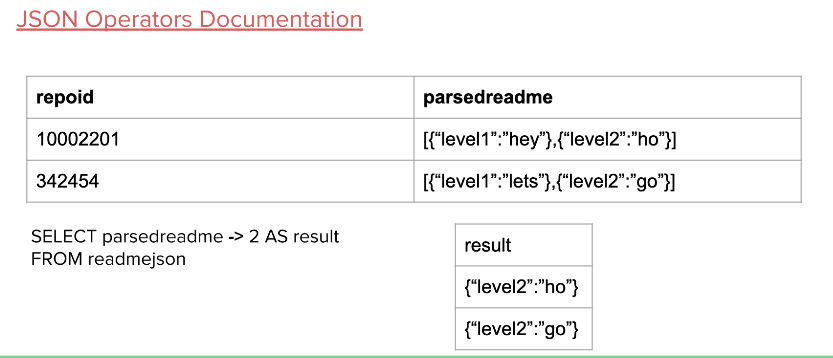

or

```sql
SELECT parsereadme #> '{2, "level2"}' As result
FROM readmejson
```

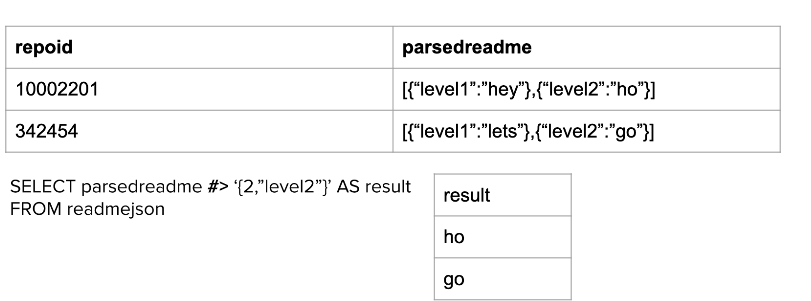


### 6. More complex queries
- With Throughput data in the DB we can now ask more complex queries
    - What top level headers are most commonly associated with R?
    
    ```sql
    SELECT header, COUNT(*)
    FROM throughtput.langauges
    JOIN throughput.repolanguages ON...
    ```
 
    - Which contributors are associated with the longest READMEs?
    - Which databases have the longest average README files, binned by the number of repositories associated with DBs?
    
- To answer complicated queries, we need to think about `KISS & DRY for SQL`!
    - `Keep It Simple, Stupid`, `Do not Repeat Yourself`
    - CTEs : KISS (Common Table Expressions)
    - VIEWS : DRY (Stored tables based on pre-defined queries)
    - FUNCTIONS : DRY (Tables and objects accepting variables

### 7. COMMON TABLE EXPRESSION

- Simplify Query structure by removing inline elements to named blocks.
- Improves readability

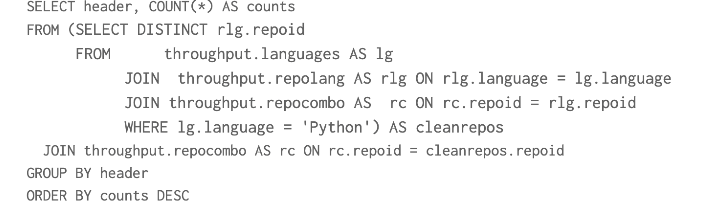

```sql
WITH cleanrepos AS (
    SELECT DISTINCT rlg.repoid
    FROM throughput.langauges AS lg
    JOIN throughput.repolang AS rlg ON rlg.language = lg.language
    JOIN throughput.repocombo AS rc ON rc.repoid = rlg.repoid
    WHERE lg.language = 'Python'
    )
SELECT header, COUNT(*) As counts
FROM cleanrepos
JOIN throughput.repocombo AS rc ON rc.repoid = cleanrepos.repoid
GROUP BY header
ORDER BY counts DESC
```

- A CTE element disappears once the query is terminated.

### 8. VIEWS (what's the diff between views and ctes?)
- Simplify Query structure
- Improve efficiency by storing frequently used (or expensive) queries to virtual tables
- A VIEW persists in the database until it is removed
    - A TEMPORARY VIEW is removed when a connection is terminated
- A VIEW cannot be updated, only recalculated.

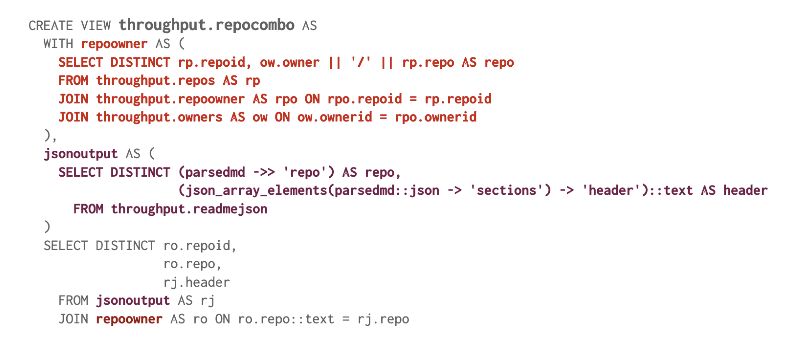

### 9. FUNCTIONS
- Functions are stored query plans that can be called by name and can accept variables.

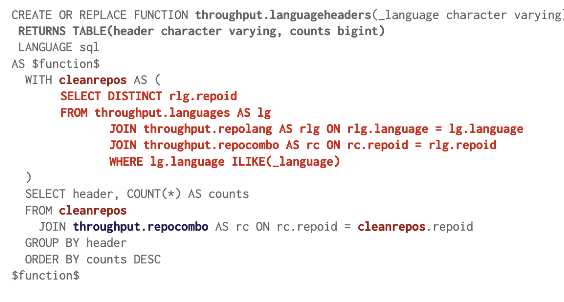

### 10. Rmd: jsonb and CTEs

#### 10. 1 Querying JSON data in PostgreSQL:
    - `->` : accepts a string or an interger to index an array
        - `->>` : gets JSON array elements / object field as text
    - `#>` : accepts an array of strings/integers that specify a path to follow through the JSON data
        - `#>>` : gets JSON obejcts at a specified path as text

```sql
-- Indexing the first element in parsedmd --
SELECT parsedmd -> 0 FROM throughput.readmejson
LIMIT 5

-- Indexing "header" in the first element in parsedmd --
SELECT parsedmd -> 0 -> 'header' FROM throughput.readmejson
LIMIT 5

-- Indexing with #> --
SELECT parsedmd #> '{0,header}' FROM throughput.readmejson
LIMIT 5
```

#### 10.2 CTE, VIEW, FUNCTIONS

|Object           |Description|SQL command|Documentation|
|-----------------|-----------|---|-------------|
|CTE              |A **temporary result** which you can use within other SQL statements.<br>It is not stored and can only be used within a single query.<br>Think of it as a `with` statement in Python.|`WITH`|[Docs](https://www.postgresql.org/docs/9.1/queries-with.html)|
|View             |Essentially **a named query that can be used in other queries**.<br>Gets re-run every time you reference it, no data is stored on disk.<br>Persists after your session has ended.|`CREATE VIEW`|[Docs](https://www.postgresql.org/docs/9.2/sql-createview.html)|
|Temporary View   |Same as above but _automatically dropped_ after the session ends.|`CREATE TEMP VIEW`|[Docs](https://www.postgresql.org/docs/9.2/sql-createview.html)|
|Materialized View|_Physically stores_ the query result on disc for faster access.<br>Needs to be refreshed if the source data changes.<br>Persists after your session has ended.|`CREATE MATERIALIZED VIEW`|[Docs](https://www.postgresql.org/docs/current/sql-creatematerializedview.html)|
|Functions        |Just like functions in R or Python.<br>Reusable code that can accept arguments.|`CREATE FUNCTION`|[Docs](https://www.postgresql.org/docs/9.1/sql-createfunction.html)|

## Lecture 5 Disk management and indexes

#### 1. Indexing
- Powerful tool

- Tradeoffs
    - Indexes provide a map of the pages within a table file, but take up space
    - size vs speed argument ( you need to balance them )

- Storing statistics
    - primary key - get index by default
    - foreign key - doesn't get index by default
    - polygon spacial data

* using indexes
    - B-tree, hash, gist, gin, brin

1. B-tree
- tries to balance across nodes to product a minimum-spanning tree.
- every single data value in the table is equidistant from the root.
- what index will do is... are you greater than 1/11? are you greather than 11/17? ... Are you looking for 20? Then it will give you the physical address for all pages. 
- Better than R. We just came through two steps and found the metadata for the data you are searching for.
- Tries to minimize between the leaf and the root.

2. Hash index
- use function turn a string to a number. 
- small, only supports quality.
- random set of characters of values
- you can only search for exact match. (not like b-tree - you can compare values)
- Really fast. Just have to go and find through the bucket that has the hash value.
- Works best with if your data has a few of unique values.  ( if not, it will be inefficient)

3. GIST
- More dimensions of data at the same time
- Spacial search

4. GIN
- inverted tree where we have individual number of words that point several sentences
- Inverse of b-tree
- large volumn of text analysis

5. BRIN
- you pages are orderes
- effective when you have large amount of data, and the data is ordered. (special kinds of index.. the order only matters for the indexing because the data is sorted in an order.)
- 

#### Am I using an index?
- "namehash" -> you are using indexes

#### Do i need an index?
- very fast when you added index
- indexes take space.

- indexes definitely speeds things up, but it takes up space. 

- Primary key vs foreign key vs index
- foreign key is not naturally indexed.
    - you can add one if its needed.
- index on a foreign key is useful if that table is very long.

### Rmd

1. define function
- select array_agg(round(random() * (max-min)) + min from generate_series(0, dim)
- select MD5((random())::text) 

2. Create indexes
- Create index tablenames on indexes.example using **bree(name)**
    - create "indexes"
    - if you do 
    ```sql
    explain analyze 
    select * from indexes.example
    where anme ilike '00%'
    limit 10
    ```
    you should see the search is using indexes.. 
    - sometimes query planner skips indexes if its not appropriate
    - using indexes helps a lot of time, but depends of your data. (**choose an appropriate indexes**)


- index is a metadata of the table (points address)
- b-tree can't handle highly unbalanced data

INDEX
- Just like the index in books
- Quick look view for contents
- Some initial input to create indexes
- Default "b-tree"
    - stick with default. (general advice)

JSONB
- JSONB read file and process (converts binary)
- JSON raw data
- `#>>` JSONB -> text dtype 

## Lecture 6: Building from the Ground up

### When do we use public data?
- There are great public data

### How do we assess quality?
- Human Readable Metadata
    - Explanation
- A data License Agreement
    - Under what condition, we can use it?
- Data Provenance
    - Where did it come from?
- Data Quality & Fitness Assessments
- Shared Data Vocabulary
    - What do the fields mean?
    - Units?
    - The vocabularies are widely accepted?
- Data Access
    - The links are public?

### Preserving and Creating Metadata
- Scripts should include data access steps so that others can reproduce the same steps

### Preserve steps & reasoning
- The result table should be related to questions

### Determine Entities and Relationships
### Consider External Data Relationships
- What kinds of data do we wanna bring in?
- Data haminomization
    - Data standarzation
    - ex) date type
    - ex) names
        - Look for standard online
    - ex) spatial data

### Data Standards for Databases
- schema.org
- Microsoft Common Data Standard

### Building Queries
- Reduce repetition
- Use our data models and queries to build a comprehensive data model with:
    - Reproducibility
        - Reproduce for yourself, for other people. 
    - Extensibility
    - Efficiency
    - Portability

- Metadata
    - About data retrieval, data reproduce info,, ... 
    

### Rmd

- Why are we building a database?
- You should be able to use the data... 